# Benchmarks experiments notebook
This notebook is an accompanying notebook to the main script <code>experiments_scripts.py</code>. 
It can be used to tune the hyper-parameters ranges and for quick testing. To run this notebook and the script, first install <code>darts</code> and the [<code>ray</code> library](https://docs.ray.io/en/latest/ray-overview/installation.html). Install [<code>optuna</code> library](https://optuna.readthedocs.io/en/stable/installation.html) to use Optuna search algorithms.  

# read data, setup directories, transform 

In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline 


from sklearn.preprocessing import MaxAbsScaler
from darts.dataprocessing.transformers import Scaler
from ray import tune

from datetime import datetime
import random
import os
from tqdm import tqdm
from darts.utils.utils import series2seq
from darts.dataprocessing.pipeline import Pipeline
from darts.metrics import mse, mae, smape, rmse, mape, mase
import torch
from pytorch_lightning.callbacks import Callback, EarlyStopping
from darts import TimeSeries
import numpy as np
import pickle
import json
import ray
from ray import tune, air
from ray.tune.search.optuna import OptunaSearch
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from darts.models.forecasting.regression_model import RegressionModel
from darts.models.forecasting.torch_forecasting_model import (MixedCovariatesTorchModel, PastCovariatesTorchModel,
                                                              FutureCovariatesTorchModel , TorchForecastingModel)
from ray.tune.schedulers import ASHAScheduler
from ray.air import session
import matplotlib.pyplot as plt
import optuna
from csv import DictWriter
from darts.utils import missing_values
from darts.utils.statistics import plot_pacf

# data and models
from darts.datasets import ETTh1Dataset, ElectricityDataset
from darts.models import TCNModel, DLinearModel, NLinearModel, NHiTSModel, LightGBMModel, LinearRegressionModel
from builders import MODEL_BUILDERS


In [2]:
IN_MIN = 5  # make argument?
IN_MAX = 30


def _params_NHITS(trial):
    in_len = trial.suggest_int("in_len", IN_MIN * PERIOD_UNIT, IN_MAX * PERIOD_UNIT)

    out_len = trial.suggest_int("out_len", 1, in_len - PERIOD_UNIT)

    num_stacks = trial.suggest_int("num_stacks", 2, 5)
    num_blocks = trial.suggest_int("num_blocks", 1, 3)
    num_layers = trial.suggest_int("num_layers", 2, 5)
    activation = trial.suggest_categorical(
        "activation",
        ["ReLU", "RReLU", "PReLU", "Softplus", "Tanh", "SELU", "LeakyReLU", "Sigmoid"],
    )

    MaxPool1d = trial.suggest_categorical("MaxPool1d", [False, True])
    dropout = trial.suggest_float("dropout", 0.0, 0.4)

    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    add_encoders = trial.suggest_categorical("add_encoders", [False, True])

    constants = {
        "layer_widths": 512,
        "pooling_kernel_sizes": None,
        "n_freq_downsample": None,
    }

    return constants


def _params_NLINEAR(trial):
    in_len = trial.suggest_int("in_len", IN_MIN * PERIOD_UNIT, IN_MAX * PERIOD_UNIT)

    out_len = trial.suggest_int("out_len", 1, in_len - PERIOD_UNIT)

    shared_weights = trial.suggest_categorical("shared_weights", [False, True])
    const_init = trial.suggest_categorical("const_init", [False, True])
    normalize = trial.suggest_categorical("normalize", [False, True])
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    add_encoders = trial.suggest_categorical("add_encoders", [False, True])

    return None


def _params_DLINEAR(trial):

    in_len = trial.suggest_int("in_len", IN_MIN * PERIOD_UNIT, IN_MAX * PERIOD_UNIT)

    out_len = trial.suggest_int("out_len", 1, in_len - PERIOD_UNIT)

    kernel_size = trial.suggest_int("kernel_size", 5, 25)
    shared_weights = trial.suggest_categorical("shared_weights", [False, True])
    const_init = trial.suggest_categorical("const_init", [False, True])
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    add_encoders = trial.suggest_categorical("add_encoders", [False, True])

    return None


def _params_TCNMODEL(trial):

    in_len = trial.suggest_int("in_len", IN_MIN * PERIOD_UNIT, IN_MAX * PERIOD_UNIT)

    out_len = trial.suggest_int("out_len", 1, in_len - PERIOD_UNIT)

    kernel_size = trial.suggest_int("kernel_size", 5, 25)
    num_filters = trial.suggest_int("num_filters", 5, 25)
    weight_norm = trial.suggest_categorical("weight_norm", [False, True])
    dilation_base = trial.suggest_int("dilation_base", 2, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    add_encoders = trial.suggest_categorical("add_encoders", [False, True])

    return None


def _params_LGBMModel(trial):

    lags = trial.suggest_int("lags", IN_MIN * PERIOD_UNIT, IN_MAX * PERIOD_UNIT)
    out_len = trial.suggest_int("out_len", 1, lags - PERIOD_UNIT)

    boosting = trial.suggest_categorical("boosting", ["gbdt", "dart"])
    num_leaves = trial.suggest_int("num_leaves", 2, 50)
    max_bin = trial.suggest_int("max_bin", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 1e-8, 1e-1, log=True)
    num_iterations = trial.suggest_int("num_iterations", 50, 500)
    add_encoders = trial.suggest_categorical("add_encoders", [False, True])

    return None


def _params_LinearRegression(trial):

    lags = trial.suggest_int("lags", IN_MIN * PERIOD_UNIT, IN_MAX * PERIOD_UNIT)
    out_len = trial.suggest_int("out_len", 1, lags - PERIOD_UNIT)

    add_encoders = trial.suggest_categorical("add_encoders", [False, True])

    return None


PARAMS_GENERATORS = {
    TCNModel.__name__: _params_TCNMODEL,
    DLinearModel.__name__: _params_DLINEAR,
    NLinearModel.__name__: _params_NLINEAR,
    NHiTSModel.__name__: _params_NHITS,
    LightGBMModel.__name__: _params_LGBMModel,
    LinearRegressionModel.__name__: _params_LinearRegression,
}

## configure experiment

In [3]:
dataset = ETTh1Dataset
model_cl = DLinearModel#LinearRegressionModel#LightGBMModel#DLinearModel#TCNModel #NHiTSModel#
random_seed = 42 

# data
PERIOD_UNIT = 24 
subset_size = int(365*1.5) * PERIOD_UNIT
split = 0.7
load_as_multivariate = False 
encoders_past = {"datetime_attribute": {"past": ["month", "week", "hour","dayofweek"]},
                "cyclic": {"past": ["month", "week", "hour", "dayofweek"]}} 
encoders_future = {"datetime_attribute": {"future": ["month", "week", "hour","dayofweek"]},
                    "cyclic": {"future": ["month", "week", "hour", "dayofweek"]}}

encoders = encoders_future if issubclass(model_cl, (MixedCovariatesTorchModel, FutureCovariatesTorchModel,RegressionModel))\
            else encoders_past

# model training
fixed_params={
    "BATCH_SIZE" : 1024,
    "MAX_N_EPOCHS": 100,
    "NR_EPOCHS_VAL_PERIOD": 1,
    "MAX_SAMPLES_PER_TS": 1000, 
    "RANDOM_STATE": random_seed
}

optimize_with_metric = True # whether optimize models based on a metric or based on val_loss
eval_metric = smape
time_budget = 300 # in seconds


## setup logging directory

In [4]:
#Fix random states
#https://pytorch.org/docs/stable/notes/randomness.html
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.use_deterministic_algorithms(True)

exp_start_time = datetime.now()
exp_name = f"{model_cl.__name__}_{exp_start_time.strftime('%Y-%m-%d')}_pid{os.getpid()}_seed{random_seed}"

# create directories 
experiment_root = os.path.join(os.getcwd(), f"benchmark_experiments/{dataset.__name__}")
experiment_dir = os.path.join(os.getcwd(), f"{experiment_root}/{exp_name}")
print(experiment_dir)
os.makedirs(experiment_dir, exist_ok=True)

/Users/elianemaalouf/PycharmProjects/darts_original/experiments/benchmark_experiments/ETTh1Dataset/DLinearModel_2023-01-30_pid14911_seed42


## read data and split

In [5]:

#read data 
if "multivariate" in dataset.__init__.__code__.co_varnames:
    data = dataset(multivariate=load_as_multivariate).load()
else:
    data = dataset().load()

data = series2seq(data)

data = [
    s[-subset_size:].astype(np.float32) for s in tqdm(data)
]


# split : train, validation , test (validation and test have same length)
all_splits = [list(s.split_after(split)) for s in data]
train_original = [split[0] for split in all_splits]
vals = [split[1] for split in all_splits]
vals = [list(s.split_after(0.5)) for s in vals]
val_original = [s[0] for s in vals]
test_original = [s[1] for s in vals]


train_len = len(train_original[0])
val_len = len(val_original[0])
test_len = len(test_original[0])
num_series = len(train_original)
n_components = train_original[0].n_components

print("number of series:", num_series)
print("number of components:", n_components)
print("training series length:", train_len)
print("validation series length:", val_len)
print("test series length:", test_len)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 120.88it/s]

number of series: 1
number of components: 7
training series length: 9189
validation series length: 1970
test series length: 1969


## Check missing values and transform data

In [6]:
# check if missing values and fill
for i in range(num_series):
    missing_ratio = missing_values.missing_values_ratio(train_original[i])
    print(f"missing values ratio in training series {i} = {missing_ratio}")
    print("filling training missing values by interpolation")
    if missing_ratio > 0.0:
        missing_values.fill_missing_values(train_original[i])
    
    missing_ratio = missing_values.missing_values_ratio(val_original[i])
    print(f"missing values ratio in validation series {i} = {missing_ratio}")
    print("filling validation missing values by interpolation")
    if missing_ratio > 0.0:
        missing_values.fill_missing_values(val_original[i])
    
    missing_ratio = missing_values.missing_values_ratio(test_original[i])
    print(f"missing values ratio in test series {i} = {missing_ratio}")
    print("filling test missing values by interpolation")
    if missing_ratio > 0.0:
        missing_values.fill_missing_values(test_original[i])
    

missing values ratio in training series 0 = 0.0
filling training missing values by interpolation
missing values ratio in validation series 0 = 0.0
filling validation missing values by interpolation
missing values ratio in test series 0 = 0.0
filling test missing values by interpolation


In [7]:
scaler = (
        Scaler(scaler=MaxAbsScaler())
        if issubclass(model_cl, TorchForecastingModel)
        else None
    )

if scaler is not None:
    train = scaler.fit_transform(train_original)
    val = scaler.transform(val_original)
    test = scaler.transform(test_original)
else:
    train = train_original
    val = val_original
    test = test_original

## plot some data and checks

all components: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']


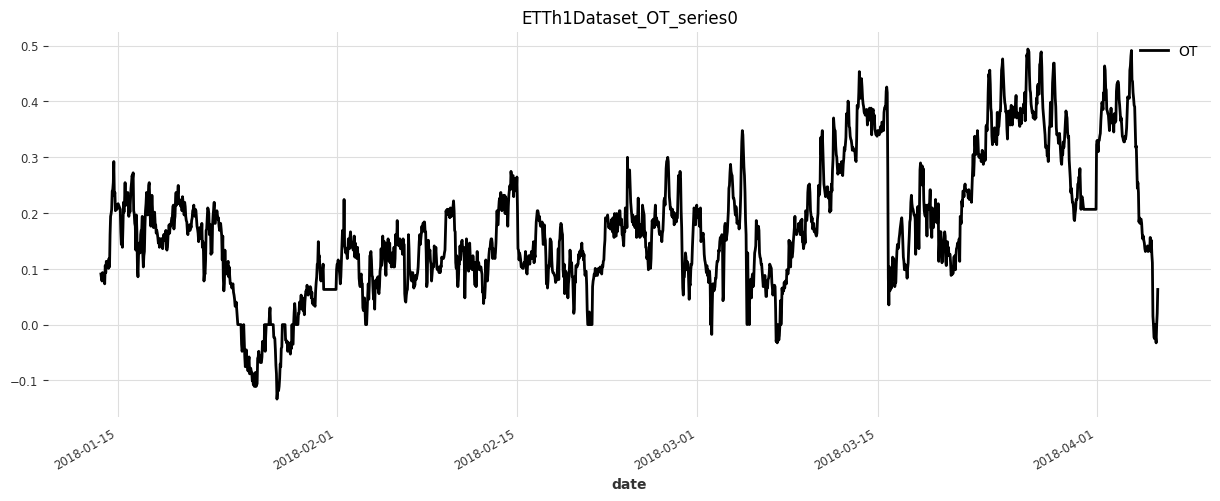

KeyboardInterrupt: 

In [8]:
# pick series and components at random to plot 
max_series_to_plot = 5
max_comps_to_plot = 5


if n_components < max_comps_to_plot:
    max_comps_to_plot = n_components

comps_vec = np.random.randint(0, n_components, max_series_to_plot)
comp_names = train[0].columns.to_list()

if num_series < max_series_to_plot:
    max_series_to_plot = num_series

print("all components:", comp_names)
series_vec = np.random.randint(0, num_series, max_series_to_plot)

for idx in series_vec:
    for comp_id in comps_vec:
        comp_id = comp_names[comp_id]
        plt.figure(figsize=(15, 5))
        val[idx][comp_id].plot()
        plt.title(f"{dataset.__name__}_{comp_id}_series{idx}")
        plt.show()
        plt.close()
        
        plot_pacf(val[idx][comp_id], max_lag = IN_MAX * PERIOD_UNIT)


# setup optimiztation function and tuner

In [9]:
def objective_val_loss(
    config, model_cl, encoders, fixed_params, train=train, val=val
):

    metrics = {"metric": "val_loss"}

    callbacks = [TuneReportCallback(metrics, on="validation_end")]

    model = MODEL_BUILDERS[model_cl.__name__](
        **config, fixed_params=fixed_params, encoders=encoders, callbacks=callbacks
    )

    # train the model
    if isinstance(model, (TorchForecastingModel, LightGBMModel)):
        model.fit(
            series=train,
            val_series=val,
            max_samples_per_ts=fixed_params["MAX_SAMPLES_PER_TS"],
        )
    else:
        model.fit(
            series=train, max_samples_per_ts=fixed_params["MAX_SAMPLES_PER_TS"]
        )

def objective_metric(
    config, model_cl, metric, encoders, fixed_params, train=train, val=val
):
    model = MODEL_BUILDERS[model_cl.__name__](
        **config, encoders=encoders, fixed_params=fixed_params
    )

    # train the model
    if isinstance(model, (TorchForecastingModel, LightGBMModel)):
        print("TRUE")
        model.fit(
            series=train,
            val_series=val,
            max_samples_per_ts=fixed_params["MAX_SAMPLES_PER_TS"],
        )
    else:
        model.fit(
            series=train, max_samples_per_ts=fixed_params["MAX_SAMPLES_PER_TS"]
        )

    # DL Models : use best model for subsequent evaluation
    if isinstance(model, TorchForecastingModel):
        model = model_cl.load_from_checkpoint(
            model_cl.__name__, work_dir=os.getcwd(), best=True
        )

    preds = model.predict(series=train, n=val_len)

    if metric.__name__ == "mase":
        metric_evals = metric(val, preds, train, n_jobs=-1, verbose=True)
    else:
        metric_evals = metric(val, preds, n_jobs=-1, verbose=True)

    metric_evals_reduced = (
        np.mean(metric_evals) if metric_evals != np.nan else float("inf")
    )

    session.report({"metric": metric_evals_reduced})

objective_metric_with_params = tune.with_parameters(
    objective_metric,
    model_cl=model_cl,
    metric=eval_metric,
    encoders=encoders,
    fixed_params=fixed_params,
    train=train,
    val=val,
)

objective_val_loss_with_params = tune.with_parameters(
    objective_val_loss,
    model_cl=model_cl,
    encoders=encoders,
    fixed_params=fixed_params,
    train=train,
    val=val,
)

# https://docs.ray.io/en/latest/tune/examples/optuna_example.html
# the default optuna algorithm is TPEsampler
search_alg = OptunaSearch(
    space=PARAMS_GENERATORS[model_cl.__name__],
    metric="metric",
    mode="min",
)

tuner = tune.Tuner(
    trainable=objective_metric_with_params
    if optimize_with_metric
    else objective_val_loss_with_params,
    tune_config=tune.TuneConfig(
        search_alg=search_alg,
        num_samples=-1,
        time_budget_s=time_budget,
    ),
    run_config=air.RunConfig(
        local_dir=experiment_dir,
        name=f"{model_cl.__name__}_tuner_{eval_metric.__name__}",
    ),
)


[I 2023-01-30 16:19:55,844] A new study created in memory with name: optuna


# run hyperparameters tuner

In [ ]:
# run optimizer
tuner_results = tuner.fit()

2023-01-30 16:20:00,833	INFO worker.py:1538 -- Started a local Ray instance.


(objective_metric pid=14985) TRUE


(objective_metric pid=14985) GPU available: False, used: False
(objective_metric pid=14985) TPU available: False, using: 0 TPU cores
(objective_metric pid=14985) IPU available: False, using: 0 IPUs
(objective_metric pid=14985) HPU available: False, using: 0 HPUs
(objective_metric pid=14985) 
(objective_metric pid=14985)   | Name            | Type             | Params
(objective_metric pid=14985) -----------------------------------------------------
(objective_metric pid=14985) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=14985) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=14985) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=14985) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=14985) 4 | linear_seasonal | Linear           | 15.9 M
(objective_metric pid=14985) 5 | linear_trend    | Linear           | 15.9 M
(objective_metric pid=14985) 6 | linear_fut_cov  | Linear           | 91    
(objecti

Sanity Checking: 0it [00:00, ?it/s]5) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-30 16:20:06,954	ERROR trial_runner.py:1088 -- Trial objective_metric_3b245830: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=14985, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, ch

Trial name,date,experiment_id,hostname,node_ip,pid,timestamp,trial_id
objective_metric_02180e5a,2023-01-30_16-20-23,5258f2533d4749be9e3315ea51ce42f0,eliane.maalouf,127.0.0.1,15021,1675092023,02180e5a
objective_metric_1b1ecef6,2023-01-30_16-20-11,4a451a5c708a4346842b71fbdcbaf6b8,eliane.maalouf,127.0.0.1,15020,1675092011,1b1ecef6
objective_metric_3b245830,2023-01-30_16-20-06,96c8689da1ed48b1911c34cd6da8482a,eliane.maalouf,127.0.0.1,14985,1675092006,3b245830
objective_metric_534446bc,2023-01-30_16-20-11,bb04853c2d7b47759b2e0d070fbdd340,eliane.maalouf,127.0.0.1,15016,1675092011,534446bc
objective_metric_5fe270a4,2023-01-30_16-20-11,9e6fecb6b5f247d48e4caa58999617ad,eliane.maalouf,127.0.0.1,15019,1675092011,5fe270a4
objective_metric_6b8b5091,2023-01-30_16-20-16,0f7c534e0cf54e0286e3024ffc915e1a,eliane.maalouf,127.0.0.1,15049,1675092016,6b8b5091
objective_metric_86dc4d30,2023-01-30_16-20-22,5258f2533d4749be9e3315ea51ce42f0,eliane.maalouf,127.0.0.1,15021,1675092022,86dc4d30
objective_metric_8870dd22,2023-01-30_16-20-11,cc4b367b662f4bb690dc958a2c6572c2,eliane.maalouf,127.0.0.1,15017,1675092011,8870dd22
objective_metric_d0e1cb8f,2023-01-30_16-20-22,0ac7fa35dade48eb9fdb6e64823789f4,eliane.maalouf,127.0.0.1,15057,1675092022,d0e1cb8f
objective_metric_f6d78226,2023-01-30_16-20-11,09e7bc34d70640b29156d2f3a5a7e577,eliane.maalouf,127.0.0.1,15022,1675092011,f6d78226


(objective_metric pid=14985) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=14985)   warnings.warn('resource_tracker: There appear to be %d '


(objective_metric pid=15016) TRUE
(objective_metric pid=15019) TRUE
(objective_metric pid=15021) TRUE
Sanity Checking: 0it [00:00, ?it/s]
(objective_metric pid=15017) TRUE
Sanity Checking: 0it [00:00, ?it/s]
(objective_metric pid=15020) TRUE


(objective_metric pid=15019) ValueError: Covariates have been provided, but the model has been built with shared_weights=True.Please set shared_weights=False to use covariates.
(objective_metric pid=15016) ValueError: Covariates have been provided, but the model has been built with shared_weights=True.Please set shared_weights=False to use covariates.
(objective_metric pid=15017) GPU available: False, used: False
(objective_metric pid=15017) TPU available: False, using: 0 TPU cores
(objective_metric pid=15017) IPU available: False, using: 0 IPUs
(objective_metric pid=15017) HPU available: False, using: 0 HPUs
(objective_metric pid=15017) 
(objective_metric pid=15017)   | Name            | Type             | Params
(objective_metric pid=15017) -----------------------------------------------------
(objective_metric pid=15017) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=15017) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=15017) 2 | val_me

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15018) TRUE


(objective_metric pid=15018) GPU available: False, used: False
(objective_metric pid=15018) TPU available: False, using: 0 TPU cores
(objective_metric pid=15018) IPU available: False, using: 0 IPUs
(objective_metric pid=15018) HPU available: False, using: 0 HPUs
(objective_metric pid=15018) 
(objective_metric pid=15018)   | Name            | Type             | Params
(objective_metric pid=15018) -----------------------------------------------------
(objective_metric pid=15018) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=15018) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=15018) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=15018) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=15018) 4 | linear_seasonal | Linear           | 2.2 M 
(objective_metric pid=15018) 5 | linear_trend    | Linear           | 2.2 M 
(objective_metric pid=15018) -----------------------------------------------------
(o

Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 
Sanity Checking: 0it [00:00, ?it/s]
(objective_metric pid=15022) TRUE


2023-01-30 16:20:11,921	ERROR trial_runner.py:1088 -- Trial objective_metric_8870dd22: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=15017, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, ch

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=15017) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=15017)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=0.0498, train_loss=0.0498]
Validation: 0it [00:00, ?it/s]021) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=15021) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15021) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0498, train_loss=0.0498, val_loss=0.0583]        
Sanity Checking: 0it [00:00, ?it/s]0) 


(objective_metric pid=15020) GPU available: False, used: False
(objective_metric pid=15021) Metric val_loss improved. New best score: 0.058
(objective_metric pid=15020) TPU available: False, using: 0 TPU cores
(objective_metric pid=15020) IPU available: False, using: 0 IPUs
(objective_metric pid=15020) HPU available: False, using: 0 HPUs
(objective_metric pid=15020) 
(objective_metric pid=15020)   | Name            | Type             | Params
(objective_metric pid=15020) -----------------------------------------------------
(objective_metric pid=15020) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=15020) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=15020) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=15020) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=15020) 4 | linear_seasonal | Linear           | 41.0 M
(objective_metric pid=15020) 5 | linear_trend    | Linear           | 41.0 M
(objecti

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=0.0449, train_loss=0.040, val_loss=0.0583] 
Validation: 0it [00:00, ?it/s]021) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15021) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15021) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.62it/s, loss=0.176, train_loss=0.176]
Validation: 0it [00:00, ?it/s]018) 
(objective_metric pid=15018) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=0.0426, train_loss=0.0381, val_loss=0.058]
Validation: 0it [00:00, ?it/s]021) 
(objective_metric pid=15018) 
Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s, loss=0.176, train_loss=0.176, val_loss=0.104]
(objective_metric pid=15021) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.176, train_loss=0.176, val_loss=0.104]        


(objective_metric pid=15018) Metric val_loss improved. New best score: 0.104


(objective_metric pid=15021) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0426, train_loss=0.0381, val_loss=0.0555]


(objective_metric pid=15021) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.056


Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=0.0406, train_loss=0.0345, val_loss=0.0555]
Validation: 0it [00:00, ?it/s]021) 
(objective_metric pid=15021) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15021) 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.72it/s, loss=0.135, train_loss=0.0933, val_loss=0.104]
Validation: 0it [00:00, ?it/s]018) 


(objective_metric pid=15021) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.052


Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=0.0388, train_loss=0.0314, val_loss=0.0522]
Validation: 0it [00:00, ?it/s]021) 
(objective_metric pid=15018) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15021) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15021) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0388, train_loss=0.0314, val_loss=0.0484]        
(objective_metric pid=15018) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.135, train_loss=0.0933, val_loss=0.0758]        


(objective_metric pid=15021) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.048
(objective_metric pid=15018) Metric val_loss improved by 0.029 >= min_delta = 0.001. New best score: 0.076


Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=0.0372, train_loss=0.0292, val_loss=0.0484]
Validation: 0it [00:00, ?it/s]021) 
(objective_metric pid=15021) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15021) 
Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0372, train_loss=0.0292, val_loss=0.0444]        


(objective_metric pid=15021) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.044


Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=0.0358, train_loss=0.0273, val_loss=0.0444]
Validation: 0it [00:00, ?it/s]021) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.72it/s, loss=0.108, train_loss=0.0544, val_loss=0.0758]
Validation: 0it [00:00, ?it/s]018) 
(objective_metric pid=15021) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15018) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15021) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0358, train_loss=0.0273, val_loss=0.0408]        
(objective_metric pid=15018) 
Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  2.12it/s, loss=0.108, train_loss=0.0544, val_loss=0.0666]


(objective_metric pid=15021) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.041
(objective_metric pid=15018) Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.067


Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=0.0345, train_loss=0.0258, val_loss=0.0408]
Validation: 0it [00:00, ?it/s]021) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.108, train_loss=0.0544, val_loss=0.0666]        
(objective_metric pid=15021) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15021) 
Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0345, train_loss=0.0258, val_loss=0.0381]        


(objective_metric pid=15021) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.038


Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=0.0335, train_loss=0.025, val_loss=0.0381] 
Validation: 0it [00:00, ?it/s]021) 
(objective_metric pid=15021) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.70it/s, loss=0.0923, train_loss=0.045, val_loss=0.0666]
Validation: 0it [00:00, ?it/s]018) 
(objective_metric pid=15021) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0335, train_loss=0.025, val_loss=0.0365]        
(objective_metric pid=15018) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=15021) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.037
2023-01-30 16:20:16,221	ERROR trial_runner.py:1088 -- Trial objective_metric_1b1ecef6: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=15020, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmar

(objective_metric pid=15020) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=15020)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=15022) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=15022)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=15049) GPU available: False, used: False
(objective_metric pid=15049) TPU available: False, using: 0 TPU cores
(objective_metric pid=15049) IPU available: False, using: 0 IPUs
(objective_metric pid=15049) HPU available: False, using: 0 HPUs
(objective_metric pid=15049) 
(objective_metric pid=15049)   

Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=0.0326, train_loss=0.0244, val_loss=0.0365]
Validation: 0it [00:00, ?it/s]021) 
(objective_metric pid=15018) 
Epoch 3: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s, loss=0.0923, train_loss=0.045, val_loss=0.0659]
(objective_metric pid=15049) TRUE
(objective_metric pid=15021) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0923, train_loss=0.045, val_loss=0.0659]        
(objective_metric pid=15021) 
Epoch 9: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s, loss=0.0326, train_loss=0.0244, val_loss=0.0356]
Sanity Checking: 0it [00:00, ?it/s]9) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-30 16:20:16,844	ERROR trial_runner.py:1088 -- Trial objective_metric_6b8b5091: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=15049, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, ch

Epoch 10:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=0.0317, train_loss=0.0234, val_loss=0.0356]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=15021) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=15021) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.035


(objective_metric pid=15021) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.64it/s, loss=0.0833, train_loss=0.0476, val_loss=0.0659]
Validation: 0it [00:00, ?it/s]018) 
(objective_metric pid=15018) 
Epoch 11:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=0.031, train_loss=0.0225, val_loss=0.0353] 
Validation: 0it [00:00, ?it/s]021) 
(objective_metric pid=15021) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15018) 
Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s, loss=0.0833, train_loss=0.0476, val_loss=0.0663]
(objective_metric pid=15021) 
Epoch 12:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=0.0303, train_loss=0.0218, val_loss=0.0357]
Validation: 0it [00:00, ?it/s]021) 
(objective_metric pid=15021) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15021) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.078, train_loss=0.0512, val_loss=0.0663] 
Validation: 0it [00:00, ?it/s]018)

(objective_metric pid=15021) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.035. Signaling Trainer to stop.
(objective_metric pid=15021) GPU available: False, used: False
(objective_metric pid=15021) TPU available: False, using: 0 TPU cores
(objective_metric pid=15021) IPU available: False, using: 0 IPUs
(objective_metric pid=15021) HPU available: False, using: 0 HPUs
(objective_metric pid=15018) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.065
100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0742, train_loss=0.0518, val_loss=0.0655]
Validation: 0it [00:00, ?it/s]018) 
(objective_metric pid=15018) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15018) 
Epoch 6: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s, loss=0.0742, train_loss=0.0518, val_loss=0.0633]


(objective_metric pid=15018) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.063


Epoch 7:  50%|█████     | 1/2 [00:01<00:01,  1.11s/it, loss=0.0712, train_loss=0.0496, val_loss=0.0633]
Validation: 0it [00:00, ?it/s]018) 
(objective_metric pid=15018) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15018) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.0712, train_loss=0.0496, val_loss=0.0602]


(objective_metric pid=15018) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.060


Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0683, train_loss=0.0458, val_loss=0.0602]
Validation: 0it [00:00, ?it/s]018) 
(objective_metric pid=15055) TRUE
(objective_metric pid=15054) TRUE
(objective_metric pid=15056) TRUE
(objective_metric pid=15018) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]5) 
Sanity Checking: 0it [00:00, ?it/s]6) 
(objective_metric pid=15057) TRUE
Sanity Checking: 0it [00:00, ?it/s]4) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=15054) GPU available: False, used: False
(objective_metric pid=15055) GPU available: False, used: False
(objective_metric pid=15055) TPU available: False, using: 0 TPU cores
(objective_metric pid=15055) IPU available: False, using: 0 IPUs
(objective_metric pid=15055) HPU available: False, using: 0 HPUs
(objective_metric pid=15055) 
(objective_metric pid=15055)   | Name            | Type             | Params
(objective_metric pid=15055) -----------------------------------------------------
(objective_metric pid=15055) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=15055) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=15055) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=15055) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=15055) 4 | linear_seasonal | Linear           | 8.6 M 
(objective_metric pid=15055) 5 | linear_trend    | Linear           | 8.6 M 
(objective_metric pid=

(objective_metric pid=15018) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15058) TRUE


(objective_metric pid=15018) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.057


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=0.0502, train_loss=0.0502]
Validation: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 
(objective_metric pid=15056) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=15058) GPU available: False, used: False
(objective_metric pid=15058) TPU available: False, using: 0 TPU cores
(objective_metric pid=15058) IPU available: False, using: 0 IPUs
(objective_metric pid=15058) HPU available: False, using: 0 HPUs
(objective_metric pid=15058) 
(objective_metric pid=15058)   | Name            | Type             | Params
(objective_metric pid=15058) -----------------------------------------------------
(objective_metric pid=15058) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=15058) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=15058) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=15058) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=15058) 4 | linear_seasonal | Linear           | 53.0 K
(objective_metric pid=15058) 5 | linear_trend    | Linear           | 53.0 K
(objective_metric pid=15058) -----------------------------------------------------
(o

(objective_metric pid=15056) 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=0.069, train_loss=0.0878, val_loss=0.0918] 
Validation: 0it [00:00, ?it/s]


(objective_metric pid=15056) Metric val_loss improved. New best score: 0.092


(objective_metric pid=15056) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15060) TRUE


2023-01-30 16:20:23,620	ERROR trial_runner.py:1088 -- Trial objective_metric_d0e1cb8f: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=15057, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, chec

Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  1.61it/s, loss=0.0656, train_loss=0.0411, val_loss=0.0567]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=15056) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.069, train_loss=0.0878, val_loss=0.0559]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=15056) Metric val_loss improved by 0.036 >= min_delta = 0.001. New best score: 0.056
(objective_metric pid=15060) GPU available: False, used: False
(objective_metric pid=15060) TPU available: False, using: 0 TPU cores
(objective_metric pid=15060) IPU available: False, using: 0 IPUs
(objective_metric pid=15060) HPU available: False, using: 0 HPUs
(objective_metric pid=15060) 
(objective_metric pid=15060)   | Name            | Type             | Params
(objective_metric pid=15060) -----------------------------------------------------
(objective_metric pid=15060) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=15060) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=15060) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=15060) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=15060) 4 | linear_seasonal | Linear           | 2.0 M 
(objective_metric pid=15060) 5 | linear_trend    | Line

(objective_metric pid=15021) TRUE
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.67it/s, loss=129, train_loss=129.0]
Validation: 0it [00:00, ?it/s]054) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=15018) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]1) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15054) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=0.0585, train_loss=0.0375, val_loss=0.0559]
Validation: 0it [00:00, ?it/s]056) 


(objective_metric pid=15021) GPU available: False, used: False
(objective_metric pid=15021) TPU available: False, using: 0 TPU cores
(objective_metric pid=15021) IPU available: False, using: 0 IPUs
(objective_metric pid=15021) HPU available: False, using: 0 HPUs
(objective_metric pid=15021) 
(objective_metric pid=15021)   | Name            | Type             | Params
(objective_metric pid=15021) -----------------------------------------------------
(objective_metric pid=15021) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=15021) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=15021) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=15021) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=15021) 4 | linear_seasonal | Linear           | 3.7 M 
(objective_metric pid=15021) 5 | linear_trend    | Linear           | 3.7 M 
(objective_metric pid=15021) 6 | linear_fut_cov  | Linear           | 91    
(objecti

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=15018) 
Epoch 9: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s, loss=0.0656, train_loss=0.0411, val_loss=0.0535]
(objective_metric pid=15054) 
Epoch 0: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s, loss=129, train_loss=129.0, val_loss=10.90]
(objective_metric pid=15056) 
Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s, loss=0.0585, train_loss=0.0375, val_loss=0.0509]


(objective_metric pid=15018) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.054
(objective_metric pid=15054) Metric val_loss improved. New best score: 10.918
(objective_metric pid=15056) Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.051
2023-01-30 16:20:24,290	ERROR trial_runner.py:1088 -- Trial objective_metric_02180e5a: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=15021, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib

Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.23it/s, loss=0.04, train_loss=0.040]
Validation: 0it [00:00, ?it/s]058) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=15058) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=0.0526, train_loss=0.0348, val_loss=0.0509]
Validation: 0it [00:00, ?it/s]056) 


In [ ]:
# get best results 
best_params = tuner_results.get_best_result(metric = "metric", mode = "min").config
print("best parameters:", best_params)

# train best model

In [ ]:

best_model = MODEL_BUILDERS[model_cl.__name__](**best_params, 
                                               encoders = encoders,
                                               fixed_params=fixed_params, work_dir=experiment_dir)

if isinstance(best_model, TorchForecastingModel):
    best_model.n_epochs = fixed_params["MAX_N_EPOCHS"] + 50

train_start_time= datetime.now()
# train the model
if isinstance(model, (TorchForecastingModel, LightGBMModel)):
    best_model.fit(
        series=train,
        val_series=val,
        max_samples_per_ts=fixed_params["MAX_SAMPLES_PER_TS"],
    )
else:
    best_model.fit(
        series=train,
        max_samples_per_ts=fixed_params["MAX_SAMPLES_PER_TS"],
    )
train_end_time = datetime.now()
training_time = (train_end_time - train_start_time).total_seconds()

# inference with best model

In [ ]:
inference_start_time = datetime.now()
test_predictions = best_model.predict(series = val, n = test_len)
inference_end_time = datetime.now()
inference_time = (inference_end_time - inference_start_time).total_seconds()

## best model performance

In [ ]:
if eval_metric.__name__ == "mase":
    metric_evals = eval_metric(test, test_predictions, train, n_jobs=-1, verbose=True)
else:
    metric_evals = eval_metric(test, test_predictions, n_jobs=-1, verbose=True)

metric_evals_mean = np.mean(metric_evals) if metric_evals != np.nan else float("inf")
metric_evals_std= np.std(metric_evals)
print(f"{eval_metric.__name__} mean = {metric_evals_mean}, std = {metric_evals_std}")

# plot forecasts

In [ ]:
# pick series and components at random to plot 
max_series_to_plot = 5
max_comps_to_plot = 5


if n_components < max_comps_to_plot:
    max_comps_to_plot = n_components

comps_vec = np.random.randint(0, n_components, max_series_to_plot)
comp_names = train[0].columns.to_list()

if num_series < max_series_to_plot:
    max_series_to_plot = num_series

print("all components:", comp_names)
series_vec = np.random.randint(0, num_series, max_series_to_plot)

for idx in series_vec:
    for comp_id in comps_vec:
        comp_id = comp_names[comp_id]
        plt.figure(figsize=(15, 5))
        val[idx][comp_id][-(val_len//4):].plot()
        test[idx][comp_id].plot(label='actual')
        test_predictions[idx][comp_id].plot(label='forecast')
        plt.title(f"{dataset.__name__}_{comp_id}_series{idx}")
        plt.show()
        plt.close()